In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np

# Configuration

In [2]:
N_rho = 128
N_l = 3
qprop_dim = 44
initial_m = None

N_p = 30

rho_max = 3.0
rho_min = rho_max / N_rho
rho_p_lim = (0, rho_max)

psi_dtype = complex

ndim_p = 3

num_of_stencils = 2

min_delta_t = 0.00005
ode_solver_kwargs = {'min_delta_t':min_delta_t}

t_0 = 0.0
delta_t = 0.05
t_max = 5.0

In [3]:
N_t = int((t_max - t_0) / delta_t) + 1
t_arr = t_0 + np.arange(N_t) * delta_t
t_arr

delta_t_arr = np.diff(t_arr)
N_t_step = delta_t_arr.size

In [4]:
from qprop.grid import Grid
N_lm = Grid.get_num_of_phi_lm(qprop_dim, N_l)

# [NOTE] `lm_arr` is an array-type for 1D list of 2-tuples: (l,m)
lm_arr = Grid.get_l_m_array(qprop_dim, N_l, initial_m=initial_m)
l_arr, m_arr = lm_arr[:,0], lm_arr[:,1]

In [5]:
rho_arr = np.linspace(rho_min, rho_max, N_rho)
from tdse.finite_difference import it_seems_increasing_equidistanced_arr
assert it_seems_increasing_equidistanced_arr(rho_arr)
delta_rho = rho_arr[1] - rho_arr[0]

# Sample initial position of each particles $\mathbf{r_{p}}=(\rho_{p}, \theta_{p}, \phi_{p})$

In [6]:
r_p_arr_shape = (N_p, ndim_p)
r_p_arr_t0 = np.empty(r_p_arr_shape, dtype=float)

r_p_arr_t0[:,0] = np.linspace(rho_min + delta_rho, rho_max - delta_rho, N_p)
r_p_arr_t0[:,1] = 0.5 * np.pi
r_p_arr_t0[:,2] = 0.0

r_p_arr = r_p_arr_t0.copy()
rho_p_arr, theta_p_arr, phi_p_arr = r_p_arr[:,0], r_p_arr[:,1], r_p_arr[:,2]

# Initialize `psi_arr`

# Define function

In [7]:
from bohm.velocity import eval_v_p_arr_for_sph_harm_basis

Couldn't import `mpi4py` module


In [8]:
import numpy as np

class Butcher_Tableau(object):
#     kind_list = ['explicit', 'implicit']
    def __init__(self, A, b, c, b_star=None):
        """Construct a Butcher tableau
        
        # Notation
        - `N_s` : the number of stage(s) in the method
        
        # Function Argument
        - `A`: 
          - if low-triangular: explicit method
          - else: implicit method, which is more generic.
        - `b_star`: [ None | numpy.ndarray with shape (N_s,) ]
          - if None:
            : fixed-step-size method
          - if numpy.ndarray:
            : adaptive-step-size method based on the error
            : .. between the approximate solution from `b` and `b_star`
        """
        for arg in (A,b,c): assert isinstance(arg, np.ndarray)
        assert (c.ndim == 1) and (b.ndim == 1) and (A.ndim == 2)
        assert (c.size == b.size) and (A.shape == (c.size, c.size))
        _N_s = c.size
        if b_star is not None:
            assert isinstance(b_star, np.ndarray)
            b_star.shape = (_N_s,)
        
        assert self.has_consistency(A, b, c, b_star)
        
        self.A, self.b, self.c, self.b_star = A, b, c, b_star
        self.N_s = _N_s
        
    @staticmethod
    def has_consistency(A, b, c, b_star):
        _good_A_c = np.all(c == np.sum(A, axis=1))
        _good_b = b.sum() == 1.0
        _good_b_star = True
        if b_star is not None: _good_b_star = b_star.sum() == 1.0
        _all_good = _good_A_c and _good_b and _good_b_star
        return _all_good

In [9]:
N_s = 2
A = np.zeros((N_s,N_s), dtype=float)
A[1,0] = 2.0 / 3.0
b = np.array([0.25, 0.75], dtype=float)
b_star = np.array([1.0, 0.0], dtype=float)
c = np.array([0.0, 2.0 / 3.0], dtype=float)
b_table_Euler_Ralston = Butcher_Tableau(A, b, c, b_star=b_star)

N_s = 2
A = np.zeros((N_s,N_s), dtype=float)
A[1,0] = 1.0
b = np.array([0.5, 0.5], dtype=float)
b_star = np.array([1.0, 0.0], dtype=float)
c = np.array([0.0, 1.0], dtype=float)
b_table_Heun_Ralston = Butcher_Tableau(A, b, c, b_star=b_star)

N_s = 4
A = np.zeros((N_s,N_s), dtype=float)
A[1,:1] = 0.5
A[2,:2] = [0.0, 0.75]
A[3,:3] = [2.0/9.0, 1.0/3.0, 4.0/9.0]
b = np.array([2.0/9.0, 1.0/3.0, 4.0/9.0, 0.0], dtype=float)
b_star = np.array([7.0/24.0, 1.0/4.0, 1.0/3.0, 1.0/8.0], dtype=float)
c = np.array([0.0, 0.5, 0.75, 1.0], dtype=float)
b_table_Bogacki_Shampine = Butcher_Tableau(A, b, c, b_star=b_star)

b_table = b_table_Bogacki_Shampine

In [10]:
psi_arr_shape = (N_lm, N_rho)
psi_arr = np.zeros(psi_arr_shape, dtype=psi_dtype)

from tdse.analytic import hydrogen_phi_nlm
# psi_arr[0,:] = hydrogen_phi_nlm(rho_arr, n=1, l=0, m=0)  # 1s orbital - velocity check clear
# psi_arr[0,:] = hydrogen_phi_nlm(rho_arr, n=2, l=0, m=0)  # 2s orbital - velocity check clear
# psi_arr[3,:] = hydrogen_phi_nlm(rho_arr, n=2, l=1, m=1)  # 2p,m=1 orbital 


def eval_sf(rho_arr, t, psi_arr):
    _n, _l, _m = 2, 1, 1
    _phase_t = np.exp(-0.5j/_n**2 * t)
    psi_arr[3,:] = hydrogen_phi_nlm(rho_arr, n=_n, l=_l, m=_m) * _phase_t
    
#     _n, _l, _m = 1, 0, 0
#     _phase_t = np.exp(-0.5j/_n**2 * t)
#     psi_arr[0,:] = hydrogen_phi_nlm(rho_arr, n=_n, l=_l, m=_m) * _phase_t
    
psi_arr_t0 = psi_arr.copy()
eval_sf(rho_arr, t_0, psi_arr_t0)

    
def propagate_sf_analytic(psi_arr, delta_t, rho_arr, t, eval_sf, *psi_args):
    '''Propagate the given state function by `delta_t`'''
    _eval_sf, _next_time = eval_sf, t + delta_t
    _eval_sf(rho_arr, _next_time, psi_arr, *psi_args)
    return delta_t



def propagate_x_p_Ralston_Euler(r_p_arr, delta_t, psi_arr,
#                           psi_arr_at_t_0, psi_arr_at_t_2_3, 
                                rho_arr, err_p_arr, 
                                num_of_stencils, check_rho_arr, rho_p_lim, b_table, 
                                psi_args, eval_sf, current_time, lm_arr):
    
    """
    
    # Function Argument
    - `b_table`: of type `Butcher_Tableau`
    """
    _current_time_0 = current_time
    _current_time = _current_time_0
    _inner_time = 0.0
    
    _k_arr_shape = (b_table.N_s,) + r_p_arr.shape
    _k_arr = np.empty(_k_arr_shape, dtype=r_p_arr.dtype)
    
    for _k_idx in range(b_table.N_s):
        
        # Propagate the state function if needed
        _delta_t = delta_t * (b_table.c[_k_idx] - _inner_time)
        print("_delta_t: {} / _inner_time: {}".format(_delta_t, _inner_time))
        if (_delta_t > 0):
            _current_time += propagate_sf_analytic(psi_arr, _delta_t, rho_arr, _current_time, eval_sf, *psi_args)
            _inner_time = b_table.c[_k_idx]
#              = current_time + _inner_time

        _r_p_shifted_arr = r_p_arr.copy()
        for _a_idx in range(_k_idx):
            _r_p_shifted_arr += b_table.A[_k_idx,_a_idx] * _k_arr[_a_idx]
        _k_arr[_k_idx,:,:] = eval_v_p_arr_for_sph_harm_basis(
            _r_p_shifted_arr, 
            psi_arr, rho_arr, lm_arr,
            num_of_stencils, check_rho_arr=check_rho_arr, rho_p_lim=rho_p_lim)
        
#         _inner_time = b_table.c[_k_idx]
    
    if _inner_time < 1.0:
        _delta_t = delta_t * (1.0 - _inner_time)
        _current_time += propagate_sf_analytic(psi_arr, _delta_t, rho_arr, _current_time, eval_sf, *psi_args)
        _inner_time = 1.0
        
    assert np.isclose(_current_time, _current_time_0 + delta_t)
#         raise ValueError("_current_time: {} / (_current_time_0 (_current_time_0 + delta_t)+ delta_t): {}".format(_current_time, (_current_time_0 + delta_t)))
        
#     k1 = eval_v_p_arr_for_sph_harm_basis(r_p_arr, psi_arr_at_t_0, rho_arr, lm_arr,
#                       num_of_stencils, check_rho_arr=check_rho_arr, rho_p_lim=rho_p_lim)
#     k2 = eval_v_p_arr_for_sph_harm_basis(r_p_arr + 2.0/3.0*delta_t*k1, psi_arr_at_t_2_3, rho_arr, lm_arr,
#                       num_of_stencils, check_rho_arr=check_rho_arr, rho_p_lim=rho_p_lim)
#     x_p_arr[:] += delta_t * (0.25 * k1 + 0.75 * k2)  # Ralston method

    err_p_arr[:] = np.zeros_like(err_p_arr, dtype=err_p_arr.dtype)
    for _k_idx in range(b_table.N_s):
        r_p_arr[:] += delta_t * (b_table.b[_k_idx] * _k_arr[_k_idx])
        err_p_arr[:] += delta_t * (b_table.b[_k_idx] - b_table.b_star[_k_idx]) * _k_arr[_k_idx]

    # error evaluation
#     err_p_arr[:] = delta_t * (-0.75 * k1 + 0.75 * k2)

    return delta_t



def propagate_one_step(
    psi_arr, r_p_arr, v_p_arr, delta_t, rho_arr, err_p_arr, err_thres, 
    t, eval_sf, psi_args, lm_arr, num_of_stencils, b_table,
    check_rho_arr, ode_solver_kwargs, rho_p_lim=None):
    
    _min_delta_t = ode_solver_kwargs['min_delta_t']
    
    _eval_sf = eval_sf
    _current_time_0 = t
    
    psi_arr_t_0 = psi_arr.copy()
    r_p_arr_t_0 = r_p_arr.copy()
    
    _current_time = _current_time_0
    _reduce_step_size = False
    _delta_t = delta_t
    _num_of_sub_step = 1
    
    while True:
        for _sub_step_index in range(_num_of_sub_step):
#             psi_arr_c1 = psi_arr.copy()
#             c2 = 2.0/3.0
#             _current_time += propagate_sf_analytic(psi_arr, c2*_delta_t, rho_arr, _current_time, _eval_sf, *psi_args)
#             psi_arr_c2 = psi_arr
            _current_time += propagate_x_p_Ralston_Euler(
                r_p_arr, _delta_t, psi_arr, rho_arr, err_p_arr, num_of_stencils, 
                check_rho_arr, rho_p_lim, b_table, psi_args, eval_sf, _current_time, lm_arr
            )
#             propagate_x_p_Ralston_Euler(r_p_arr, _delta_t, v_p_arr, psi_arr_c1, psi_arr_c2, rho_arr, err_p_arr, num_of_stencils, check_rho_arr=check_rho_arr, rho_p_lim=rho_p_lim)
            
            if np.any(np.abs(err_p_arr) >= err_thres):
                _reduce_step_size = True
                
                psi_arr[:] = psi_arr_t_0
                r_p_arr[:] = r_p_arr_t_0
                
                _delta_t *= 0.5
                _num_of_sub_step *= 2
                _current_time = _current_time_0
                
                print("making it half to {} with num_of_sub_step: {}".format(_delta_t, _num_of_sub_step))
                if _delta_t < _min_delta_t: 
                    raise ValueError("'delta_t'(={}) is smaller then 'min_delta_t' (={})".format(_delta_t, _min_delta_t))
                break
            
#             _current_time += propagate_sf_analytic(psi_arr, (1.0-c2)*_delta_t, rho_arr, _current_time, _eval_sf, *psi_args)
        
        if _reduce_step_size:
            _reduce_step_size = False
            continue
        
        assert np.all(np.abs(err_p_arr) < err_thres)
        break    
    
    v_p_arr[:] = eval_v_p_arr_for_sph_harm_basis(r_p_arr, psi_arr, rho_arr, lm_arr, num_of_stencils, check_rho_arr=check_rho_arr, rho_p_lim=rho_p_lim)
    
    return delta_t



In [11]:
err_p_arr = np.empty_like(r_p_arr, dtype=float)
v_p_arr = np.empty_like(r_p_arr, dtype=float)
err_thres = np.array([0.1, 0.2, 0.2])

def init_data():
    global t, r_p_arr, err_p_arr, psi_arr, psi_arr_t0
    
    t = t_0
    
    psi_arr[:] = psi_arr_t0
    
    psi_arr[:] = eval_sf(rho_arr, t, psi_arr)
    r_p_arr[:] = r_p_arr_t0
    err_p_arr[:] = np.empty_like(r_p_arr, dtype=float)

In [12]:
from tdse.coordinate import move_to_canonical_range_spherical_coord_arr

In [13]:
init_data()

psi_arr[:] = psi_arr_t0

r_p_arr_t = np.empty((N_t,) + r_p_arr.shape, dtype=r_p_arr.dtype)

r_p_arr_t[0,:] = r_p_arr

# [DONE][TODO] why _inner_time only 0.0?

In [14]:
for t_index, delta_t in zip(range(1,N_t),delta_t_arr):

    t += propagate_one_step(
        psi_arr, r_p_arr, v_p_arr, delta_t, rho_arr, err_p_arr, err_thres, 
        t, eval_sf, (), lm_arr, num_of_stencils,  b_table,
        check_rho_arr=True, ode_solver_kwargs=ode_solver_kwargs, rho_p_lim=rho_p_lim)

    move_to_canonical_range_spherical_coord_arr(*r_p_arr.transpose())
    
    # Store to data arrays
    r_p_arr_t[t_index,:] = r_p_arr

_delta_t: 0.0 / _inner_time: 0.0
_delta_t: 0.025 / _inner_time: 0.0
_delta_t: 0.0125 / _inner_time: 0.5
_delta_t: 0.0125 / _inner_time: 0.75
_delta_t: 0.0 / _inner_time: 0.0
_delta_t: 0.025 / _inner_time: 0.0
_delta_t: 0.0125 / _inner_time: 0.5
_delta_t: 0.0125 / _inner_time: 0.75
_delta_t: 0.0 / _inner_time: 0.0
_delta_t: 0.02500000000000001 / _inner_time: 0.0
_delta_t: 0.012500000000000004 / _inner_time: 0.5
_delta_t: 0.012500000000000004 / _inner_time: 0.75
_delta_t: 0.0 / _inner_time: 0.0
_delta_t: 0.024999999999999994 / _inner_time: 0.0
_delta_t: 0.012499999999999997 / _inner_time: 0.5
_delta_t: 0.012499999999999997 / _inner_time: 0.75
_delta_t: 0.0 / _inner_time: 0.0
_delta_t: 0.024999999999999994 / _inner_time: 0.0
_delta_t: 0.012499999999999997 / _inner_time: 0.5
_delta_t: 0.012499999999999997 / _inner_time: 0.75
_delta_t: 0.0 / _inner_time: 0.0
_delta_t: 0.025000000000000022 / _inner_time: 0.0
_delta_t: 0.012500000000000011 / _inner_time: 0.5
_delta_t: 0.012500000000000011 / _

_delta_t: 0.0 / _inner_time: 0.0
_delta_t: 0.02499999999999991 / _inner_time: 0.0
_delta_t: 0.012499999999999956 / _inner_time: 0.5
_delta_t: 0.012499999999999956 / _inner_time: 0.75
_delta_t: 0.0 / _inner_time: 0.0
_delta_t: 0.025000000000000133 / _inner_time: 0.0
_delta_t: 0.012500000000000067 / _inner_time: 0.5
_delta_t: 0.012500000000000067 / _inner_time: 0.75
_delta_t: 0.0 / _inner_time: 0.0
_delta_t: 0.02499999999999991 / _inner_time: 0.0
_delta_t: 0.012499999999999956 / _inner_time: 0.5
_delta_t: 0.012499999999999956 / _inner_time: 0.75
_delta_t: 0.0 / _inner_time: 0.0
_delta_t: 0.025000000000000133 / _inner_time: 0.0
_delta_t: 0.012500000000000067 / _inner_time: 0.5
_delta_t: 0.012500000000000067 / _inner_time: 0.75
_delta_t: 0.0 / _inner_time: 0.0
_delta_t: 0.02499999999999991 / _inner_time: 0.0
_delta_t: 0.012499999999999956 / _inner_time: 0.5
_delta_t: 0.012499999999999956 / _inner_time: 0.75
_delta_t: 0.0 / _inner_time: 0.0
_delta_t: 0.02499999999999991 / _inner_time: 0.0
_

# Generate Analytic Solutions if possible

In [15]:
r_p_t_analytic_arr_shape = (N_t,) + r_p_arr_t0.shape
r_p_t_analytic_arr = np.empty(r_p_t_analytic_arr_shape, dtype=r_p_arr_t0.dtype)
for _t_idx, _t in enumerate(t_arr):
    r_p_t_analytic_arr[_t_idx,:,0:2] = r_p_arr_t0[:,0:2]
    r_p_t_analytic_arr[_t_idx,:,2] = r_p_arr_t0[:,2] + (_t - t_0) / r_p_arr_t0[:,0]

# Plot

In [16]:
from vis.layout import get_text_position_and_inner_alignment

from nunit.au import au2fs

In [17]:
%matplotlib inline

In [18]:
from matplotlib import rcParams
rcParams['font.size'] = 15

In [19]:
from tdse.coordinate import spherical_to_cartesian

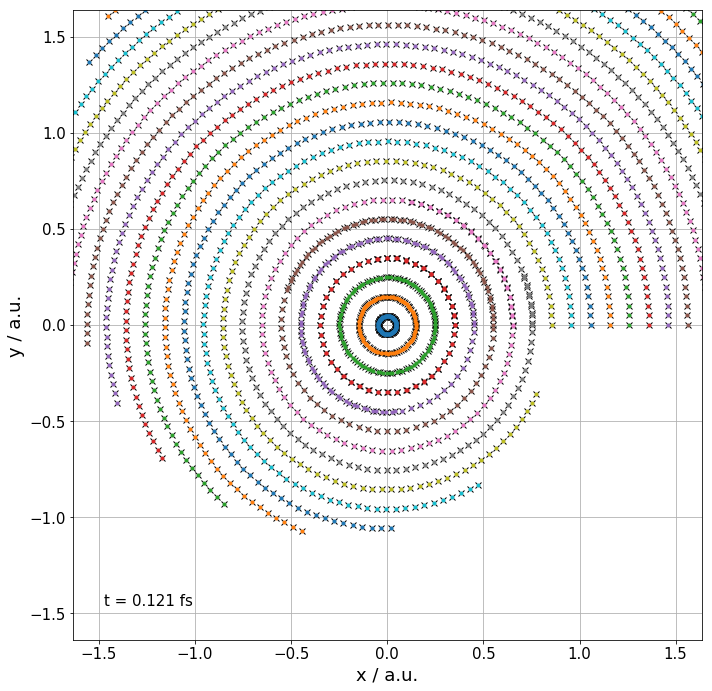

In [20]:
fig, ax = plt.subplots(figsize=(10,10))

for p_index in range(N_p):
    _rho_p_t, _theta_p_t, _phi_p_t = (r_p_arr_t[:,p_index,i] for i in range(3))
    _x_p_t, _y_p_t, _z_p_t = spherical_to_cartesian(_rho_p_t, _theta_p_t, _phi_p_t)
#     _x_p_t = _rho_p_t * np.sin(_theta_p_t) * np.cos(_phi_p_t)
#     _y_p_t = _rho_p_t * np.sin(_theta_p_t) * np.sin(_phi_p_t)
#     _z_p_t = _rho_p_t * np.cos(_theta_p_t)

    _rho_p_t_ana, _theta_p_t_ana, _phi_p_t_ana = (r_p_t_analytic_arr[:,p_index,i] for i in range(3))
    _x_p_t_ana, _y_p_t_ana, _z_p_t_ana = spherical_to_cartesian(_rho_p_t_ana, _theta_p_t_ana, _phi_p_t_ana)
    
    assert np.all(np.isclose(_z_p_t,0))
    
    line_p_analytic, = ax.plot(_x_p_t_ana, _y_p_t_ana, 'x', color='k') #line_p_numeric.get_color()
    
    line_p_numeric, = ax.plot(_x_p_t, _y_p_t, '.')
    
    
ax.axis('square')
ax.set_xlabel("x / a.u.")
ax.set_ylabel("y / a.u.")

_r_max = np.max(r_p_arr_t[:,:,0]) * 1.1 * 0.5

ax.set_xlim(-_r_max, _r_max)
ax.set_ylim(-_r_max, _r_max)


# Add time text box
text_xy, text_kwargs = get_text_position_and_inner_alignment(ax, 'sw')

time_text_format = "t = {:.3f} fs"
time_fs = t * au2fs

time_text = ax.text(*text_xy, time_text_format.format(time_fs), **text_kwargs)
# transform=ax.transAxes


# Figure tight layout
fig.tight_layout()

In [21]:
solver_name = "Bogacki-Shampine"

fig_file_name = "test-prop-on-xy-plane-t_fs-{:.3f}-r_max-{:.2f}-N_p-{}-max_delta_t_au-{:.3f}-compare-analytic-{}.png".format(time_fs, _r_max, N_p, delta_t, solver_name)
print(fig_file_name)

# "need-to-fix-different-"
fig.savefig(fig_file_name)

test-prop-on-xy-plane-t_fs-0.121-r_max-1.64-N_p-30-max_delta_t_au-0.050-compare-analytic-Bogacki-Shampine.png


# Test hydrogen energy
$$
E_n = -me^4/(2\hbar^2 n^2)\\
= -0.5/n^2 a.u.
$$